In [1]:
import sys
import cv2
import torch
import numpy as np
from math import ceil
from torch.autograd import Variable
# from scipy.ndimage import imread
import matplotlib.pyplot as plt
import models
import PIL.Image as Image

/home/yongzhang/anaconda2/lib/python2.7/site-packages/pkg_resources/__init__.py:1243: UserWarning: tmp/ is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


In [15]:
def writeFlowFile(filename,uv):
    TAG_STRING = np.array(202021.25, dtype=np.float32)
    if uv.shape[2] != 2:
        sys.exit("writeFlowFile: flow must have two bands!");
    H = np.array(uv.shape[0], dtype=np.int32)
    W = np.array(uv.shape[1], dtype=np.int32)
    with open(filename, 'wb') as f:
        f.write(TAG_STRING.tobytes())
        f.write(W.tobytes())
        f.write(H.tobytes())
        f.write(uv.tobytes())
        
def draw_flow(img, flow, step=16):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    cv.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (_x2, _y2) in lines:
        cv.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

def flow2rgb(flow_map_np, max_value=None):
    _, h, w = flow_map_np.shape
    hsv = np.ones((h,w,3), dtype=np.uint8)
    hsv[..., 1] = 255
    mag, ang = cv2.cartToPolar(flow_map_np[0].squeeze(), flow_map_np[1].squeeze())
    hsv[..., 0] = ang / (2 * np.pi) * 180
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb


# pwc_model_fn = './pwc_net_chairs.pth.tar'
pwc_model_fn = 'pwc_net.pth.tar'

net = models.pwc_dc_net(pwc_model_fn)
net = net.cuda()
net.eval()

PWCDCNet(
  (conv1a): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv1aa): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv1b): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv2a): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv2aa): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv2b): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv3a): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)

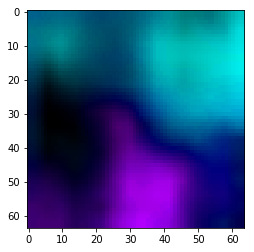

In [16]:
im1_fn = './data/input6_1.jpg'
im2_fn = './data/input6_2.jpg'
flow_fn = './tmp/frame_0010.flo'

im_all = [plt.imread(img) for img in [im1_fn, im2_fn]]
im_all = [im[:, :, :3] for im in im_all]

# rescale the image size to be multiples of 64
divisor = 64.
H = im_all[0].shape[0]
W = im_all[0].shape[1]

H_ = int(ceil(H/divisor) * divisor)
W_ = int(ceil(W/divisor) * divisor)
for i in range(len(im_all)):
    im_all[i] = cv2.resize(im_all[i], (W_, H_))

for _i, _inputs in enumerate(im_all):
    im_all[_i] = im_all[_i][:, :, ::-1]
    im_all[_i] = 1.0 * im_all[_i]/255.0

    im_all[_i] = np.transpose(im_all[_i], (2, 0, 1))
    im_all[_i] = torch.from_numpy(im_all[_i])
    im_all[_i] = im_all[_i].expand(1, im_all[_i].size()[0], im_all[_i].size()[1], im_all[_i].size()[2])	
    im_all[_i] = im_all[_i].float()
    
im_all = torch.cat(im_all,1).cuda()

flo = net(im_all)
import torch.nn.functional as F
flo = F.interpolate(flo, size=im_all[0].size()[-2:], mode='bilinear', align_corners=False)
flo = flo[0]
flo = flo.cpu().data.numpy()


# import ipdb; ipdb.set_trace()
rgb_flow = flow2rgb(flo)
# Image.fromarray(rgb_flow, 'RGB').show()
# imwrite(filename + '.png', to_save)
plt.imshow(rgb_flow)

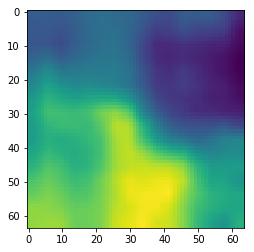

In [25]:
flo_norm = np.array((flo - flo.min()) / (flo.max() - flo.min()) * 255, 'uint8')

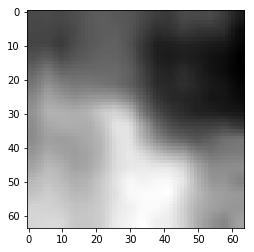

In [31]:
plt.imshow(flo_norm[0], cmap='gray')